<a href="https://colab.research.google.com/github/pedrobergaglio/rags-research/blob/main/langgraph_rag_agent_llama3_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local RAG agent with LLaMA3

We'll combine ideas from paper RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

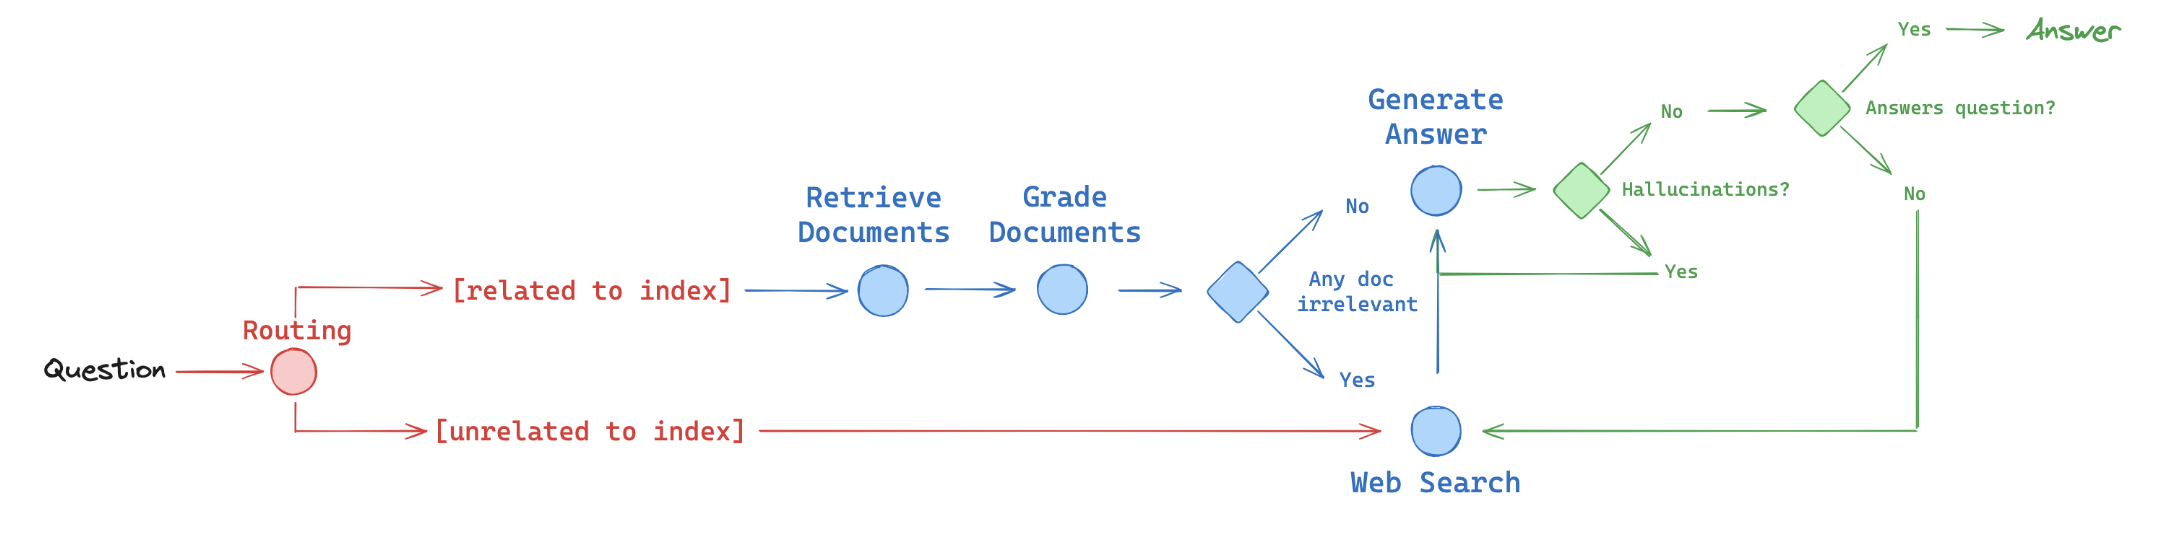!



https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/

In [ ]:
!pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
%%capture --no-stderr
%pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb firecrawl-py langchain langgraph tavily-python nomic[local] langchain-text-splitters

### Tracing (optional)

In [ ]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"

In [ ]:
### LLM

local_llm = "llama3.1"

In [ ]:
### Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import FireCrawlLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain.docstore.document import Document


urls = [
    "https://saucotec.notion.site/Infraestructura-Cloud-c335f9d3bb25494d9106d365e05f3230",
    "https://saucotec.notion.site/Integraci-n-Control-de-producci-n-Stock-8b5f41fb934340f9afdcaf833d450de1",
    "https://saucotec.notion.site/M-dulo-Metalux-para-SolidWorks-y-Odoo-18c798cf23d54fefbdc2e27c0463f200",
    "https://saucotec.notion.site/Control-de-Stock-1a224f1991b34893aafec6fbb72bdc93",
]

docs = [FireCrawlLoader(api_key='fc-30033f0e63984c5c986499b112dc3ece', url=url, mode='scrape').load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)



ModuleNotFoundError: No module named 'langchain'

In [ ]:
# Filter out complex metadata

filtered_docs = []
for doc in doc_splits:
  # Ensure the doc is a Document instance
    if isinstance(doc, Document) and hasattr(doc, 'metadata'):
        clean_metadata = {k: v for k, v in doc.metadata.items() if isinstance(v, (str, int, float, bool))}
        filtered_docs.append(Document(page_content=doc.page_content, metadata=clean_metadata))

# Add to vectorDB
vectorstore2 = Chroma.from_documents(
    documents=filtered_docs,
    collection_name="rag-chroma2",
    embedding=GPT4AllEmbeddings(),
)
retriever = vectorstore2.as_retriever()

In [ ]:
### Retrieval Grader

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Eres un calificador que evalúa la relevancia
de un documento recuperado para una pregunta del usuario. Si el documento contiene palabras clave relacionadas con la pregunta del usuario,
califícalo como relevante. No es necesario que sea una prueba estricta. El objetivo es filtrar las recuperaciones erróneas. \n
Otorga una puntuación binaria de "yes" o "no" para indicar si el documento es relevante para la pregunta. \n
Proporciona la puntuación binaria como un JSON con una clave única "score" y sin preámbulos ni explicaciones.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Aquí está el documento proporcionado: \n\n {document} \n\n
    Aquí está la pregunta del usuario: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "dónde está alojado el servicio de mails de metalux.com.ar?"
docs = retriever.invoke(question)
print(docs)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

[Document(metadata={'description': "A new tool that blends your everyday work apps into one. It's the all-in-one workspace for you and your team", 'ogDescription': "A new tool that blends your everyday work apps into one. It's the all-in-one workspace for you and your team", 'ogImage': 'https://www.notion.so/images/meta/default.png', 'ogLocale': 'en_US', 'ogSiteName': 'Notion', 'ogTitle': 'Notion – The all-in-one workspace for your notes, tasks, wikis, and databases.', 'ogUrl': 'https://www.notion.so', 'pageStatusCode': 200, 'sourceURL': 'https://saucotec.notion.site/M-dulo-Metalux-para-SolidWorks-y-Odoo-18c798cf23d54fefbdc2e27c0463f200', 'title': 'Módulo Metalux para SolidWorks y Odoo'}, page_content='Se deben extraer los archivos y carpetas enviados y ponerlos en esta carpeta. No reemplazar archivos nuevos si pregunta.\n\nMetalux.exe es el archivo a ejecutar. Se recomienda crear un acceso directo y ponerlo en escritorio (click derecho, crear acceso directo).\n\n### Contacto y Soporte

ConnectionError: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/chat (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x78e70fb5fb80>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Eres un asistente para tareas de respuesta a preguntas.
Usa los siguientes fragmentos de contexto recuperados para responder la pregunta. Si no sabes la respuesta, simplemente di que no la sabes.
Usa tres oraciones como máximo y mantén la respuesta concisa <|eot_id|><|start_header_id|>user<|end_header_id|>
    Pregunta: {question}
    Contexto: {context}
    Respuesta: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "dónde está alojado el servicio de mails de metalux.com.ar?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In [ ]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> Eres un calificador que evalúa si
una respuesta está fundamentada o respaldada por un conjunto de hechos. Da una puntuación binaria de "yes" o "no" para indicar
si la respuesta está fundamentada o respaldada por un conjunto de hechos. Proporciona la puntuación binaria como JSON con una
clave única "score" y sin preámbulo ni explicación. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Estos son los hechos:
    \n ------- \n
    {documents}
    \n ------- \n
    Acá está la respuesta: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Eres un calificador que evalúa si una
respuesta es útil para resolver una pregunta. Otorga una puntuación binaria "yes" o "no" para indicar si la respuesta es
útil para resolver una pregunta. Proporciona la puntuación binaria como JSON con una única clave "score" y sin preámbulo ni explicación.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Aquí está la respuesta:
    \n ------- \n
    {generation}
    \n ------- \n
    Aquí está la pregunta: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

In [ ]:
### Router

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> Eres un experto en enrutar una
pregunta de usuario a una vectorstore o una búsqueda web. Usa el vectorstore para preguntas sobre herramientas digitales que puedan ser utilizadas en las operaciones de una empresa. No necesitas ser estricto con las palabras clave
en la pregunta relacionada con estos temas. Si la pregunta claramente no tiene que ver con este tema, usa la búsqueda web. Da una opción binaria 'web_search'
o 'vectorstore' según la pregunta. Devuelve un JSON con una sola clave 'datasource' y
sin preámbulo ni explicación. Pregunta para enrutar: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "dónde está alojado el servicio de mails de metalux.com.ar?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

In [ ]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = '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'

web_search_tool = TavilySearchResults(k=3)

We'll implement these as a control flow in LangGraph.

### Graph Build

In [ ]:
# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [ ]:
from pprint import pprint
from typing import List

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

### State

logs = []


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


### Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    logs.append("---RETRIEVE---")
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    logs.append("---GENERATE---")
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    logs.append("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]

        # Default is web search
        web_search = "Yes"

        # Document relevant
        if grade.lower() == "yes":
            logs.append("---GRADE: DOCUMENT RELEVANT---")
            print("---GRADE: DOCUMENT RELEVANT---")
            logs.append("---DOCUMENT---")
            print("---DOCUMENT---")
            logs.append(d)
            print(d)
            logs.append("---DOCUMENT---")
            print("---DOCUMENT---")
            filtered_docs.append(d)
            # If we find a usefull document, we don't need web search
            web_search = "No"
        # Document not relevant
        """else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue"""
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    logs.append("---WEB SEARCH---")
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]

    logs.append("---WEB SEARCH RESULTS---")
    print("---WEB SEARCH RESULTS---")
    logs.append(web_results)
    print(web_results)
    logs.append("---WEB SEARCH RESULTS---")
    print("---WEB SEARCH RESULTS---")

    return {"documents": documents, "question": question}


### Conditional edge


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    #logs.append("---ROUTE QUESTION---")
    print("---ROUTE QUESTION---")
    question = state["question"]
    logs.append(question)
    #print(question)
    source = question_router.invoke({"question": question})
    #logs.append(source)
    print(source)
    #logs.append(source["datasource"])
    print(source["datasource"])
    if source["datasource"] == "web_search":
        logs.append("---ROUTE QUESTION TO WEB SEARCH---")
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        logs.append("---ROUTE QUESTION TO RAG---")
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    logs.append("---ASSESS GRADED DOCUMENTS---")
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        logs.append(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        logs.append("---DECISION: GENERATE---")
        print("---DECISION: GENERATE---")
        return "generate"


### Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    logs.append("---CHECK HALLUCINATIONS---")
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        logs.append("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        logs.append("---GRADE GENERATION vs QUESTION---")
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            logs.append("---DECISION: GENERATION ADDRESSES QUESTION---")
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            logs.append("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        logs.append("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae


In [ ]:
# Compile
app = workflow.compile()

logs = []

# Test

inputs = {"question": "en el módulo de metalux, cuáles son los pasos básicos para ejecutar el módulo?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
#pprint(value["generation"])
print(logs)

Trace:

https://smith.langchain.com/public/8d449b67-6bc4-4ecf-9153-759cd21df24f/r

In [ ]:
from pprint import pprint

# Compile
app = workflow.compile()
inputs = {"question": "en el módulo de metalux, cuáles son los formatos habilitados para los archivos?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

Trace:

https://smith.langchain.com/public/c785f9c0-f519-4a38-ad5a-febb59a2139c/r

In [ ]:
import csv
import time
from pprint import pprint

# List of questions
questions = [
    "en el módulo de metalux, cuáles son los formatos habilitados para los archivos?",
    #"dónde está alojado el servicio de mails de metalux.com.ar?",
    #"en el módulo de metalux, cuáles son los pasos básicos para ejecutar el módulo?",
]

# Open a CSV file for appending
with open('responses.csv', 'w', newline='') as csvfile:

    global logs

    writer = csv.writer(csvfile)
    writer.writerow(["Question", "Response", 'Generation', "Time Taken (s)"])  # Write header

    # Iterate over questions and get responses
    for question in questions:

        logs = []

        start_time = time.time()  # Start time tracking
        inputs = {"question": question}
        response_text = ""  # Accumulate printed output

        for output in app.stream(inputs):
            for key, value in output.items():
                pprint(f"Finished running: {key}:")  # Print progress
                #response_text += f"Finished running: {key}:\n"

        time_taken = time.time() - start_time  # Calculate time taken
        pprint(value["generation"])
        pprint(f"Time taken for '{question}': {time_taken:.2f} seconds")  # Print time taken

        # Write question, response, and time taken to CSV
        writer.writerow([question, logs, value["generation"], f"{time_taken:.2f} seconds"])

print("Responses saved to responses.csv")
